Notebook by Ayushman Buragohain



## seresnext50_32x4d + Label-Smoothing + Ranger + Flat-Anneal

In [1]:
import os
import wandb
import albumentations as A
import timm

from fastai.vision.all import *
from fastai.callback.wandb import *

from cassava_utils import *

In [2]:
SEED        = 42
IDX         = generate_random_id()
OOF_FOLD    = 0
NUM_CLASSES = 5
CSV_PATH    = '../data/fold_df.csv'
IMAGE_DIR   = '../../train_images/'
INPUT_DIMS  = 224
MODEL       = 'seresnext50_32x4d'
PROJECT     = 'kaggle-leaf-disease-fastai-runs'
SAVE_NAME   = f"{MODEL}-fold={OOF_FOLD}-{IDX}"

set_seed(SEED, reproducible=True)

Ts = [MODEL, 'ranger', 'label-smoothing', str(INPUT_DIMS) + 'mixup' + 'mish']
Ns = f'{MODEL} + Ranger + LabelSmoothing + MixUp + Mish'
run = wandb.init(project=PROJECT, tags=Ts, notes=Ns,)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Currently logged in as: ayushman (use `wandb login --relogin` to force relogin)


In [3]:
data = get_dataset(CSV_PATH, IMAGE_DIR, OOF_FOLD, shuffle=True)
data.head()

,image_id,label,filePath,kfold,is_valid
0,1587173996.jpg,Healthy,../../train_images/1587173996.jpg,2,False
1,404115232.jpg,Cassava Mosaic Disease (CMD),../../train_images/404115232.jpg,0,True
2,3945098769.jpg,Cassava Mosaic Disease (CMD),../../train_images/3945098769.jpg,1,False
3,4037735151.jpg,Cassava Mosaic Disease (CMD),../../train_images/4037735151.jpg,3,False
4,730805822.jpg,Cassava Mosaic Disease (CMD),../../train_images/730805822.jpg,1,False


In [4]:
TRAIN_AUGS = A.Compose([
    A.OneOf([A.RandomResizedCrop(INPUT_DIMS, INPUT_DIMS), A.CenterCrop(INPUT_DIMS, INPUT_DIMS)], p=0.5),
    A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0),
    A.HorizontalFlip(),
    A.OneOf([A.Rotate(), A.VerticalFlip()], p=0.5),
    A.OneOf([A.Flip(), A.IAAPerspective(), A.ShiftScaleRotate()], p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.5),
    A.OneOf([A.CLAHE(), A.HueSaturationValue(0.2, 0.2, 0.2), A.IAASharpen()], p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5, num_holes=15),
])

VALID_AUGS = A.Compose([A.Resize(INPUT_DIMS, INPUT_DIMS, p=1.0)])

ITEM_TFMS  = AlbumentationsTransform(TRAIN_AUGS, VALID_AUGS)
BATCH_TFMS = [Normalize.from_stats(*imagenet_stats)]

cassava = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  splitter=ColSplitter(),
                  get_x=lambda o: o['filePath'], 
                  get_y=lambda o: o['label'], 
                  item_tfms=ITEM_TFMS, 
                  batch_tfms=BATCH_TFMS)

dls = cassava.dataloaders(data, bs=32)

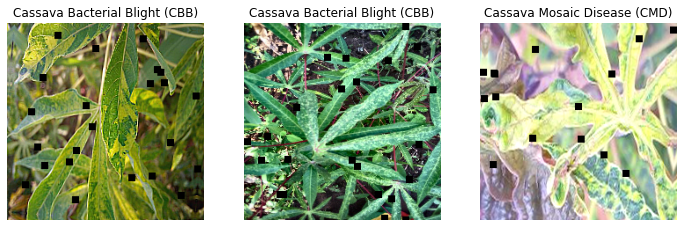

In [5]:
dls.train.show_batch(max_n=3,figsize=(12,6))

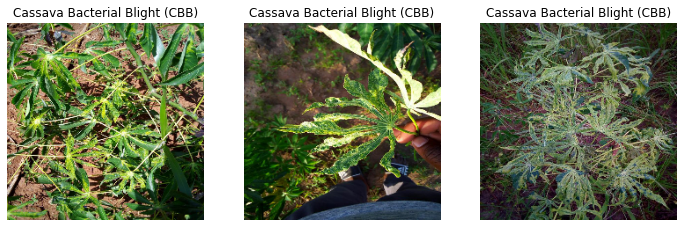

In [6]:
dls.valid.show_batch(max_n=3,figsize=(12,6))

In [12]:
@delegates(Learner)
def timm_learner(dls: DataLoaders, m_name:str, cut:int, c:int, state:str=None, 
                init:bool=True,  pretrained:bool=True, act:callable=nn.ReLU(inplace=True), 
                modifier: List[callable]=None, **kwargs):
    'create a fast.ai learner instance from timm'
    encoder = timm.create_model(m_name, pretrained=pretrained, )
    
    model  = TransferLearningModel(encoder, num_classes=c, cut=cut, act=act, init=init)
    
    if modifier is not None: 
        for mds in modifier : mds(model)
            
    if state is not None: model.load_state_dict(torch.load(state)) 
    
    learn = Learner(dls, model, **kwargs)
    return learn

In [13]:
cb_list = [WandbCallback(seed=SEED, log_preds=False, log_model=False), TerminateOnNaNCallback()]

learn = timm_learner(dls, MODEL, cut=-2, c=dls.c, pretrained=True, init=True,
                    metrics=[accuracy], splitter=custom_splitter,
                    opt_func=ranger, loss_func=LabelSmoothingCrossEntropy(),
                    cbs=cb_list).to_fp16()

In [14]:
learn.model

TransferLearningModel(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

/home/qblocks/.local/lib/python3.6/site-packages/fastai/learner.py:54: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.009120108559727669)

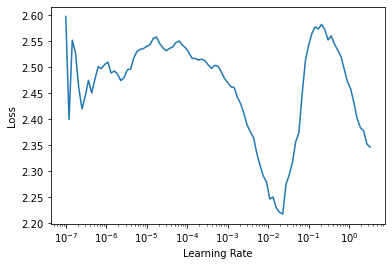

In [16]:
learn.freeze()
learn.lr_find()

In [ ]:
learn.freeze()

cb_list = [MixUp(), GradientAccumulation(n_acc=4*dls.bs)]
learn.fit_flat_cos(2, slice(2e-03), wd=0.1, cbs=cb_list)

In [ ]:
learn.save('stage-1')

In [ ]:
learn = learn.load('stage-1')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
cb_list = [MixUp(), GradientAccumulation(n_acc=4*dls.bs), SaveModelCallback(monitor='accuracy')]
learn.fit_flat_cos(15, slice(6e-04), wd=0.1, cbs=cb_list, pct_start=0.72)

In [ ]:
learn.save('stage-2')

In [ ]:
learn.load('stage-2')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
cb_list = [MixUp(), GradientAccumulation(n_acc=4*dls.bs), SaveModelCallback(monitor='accuracy')]
learn.fit_flat_cos(15, slice(6e-04), wd=0.1, cbs=cb_list, pct_start=0.72)